In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
# def sort_by_target(mnist):
#     reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
#     reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
#     mnist.data[:60000] = mnist.data[reorder_train]
#     mnist.target[:60000] = mnist.target[reorder_train]
#     mnist.data[60000:] = mnist.data[reorder_test + 60000]
#     mnist.target[60000:] = mnist.target[reorder_test + 60000]
# try:
#     from sklearn.datasets import fetch_openml
#     mnist = fetch_openml('mnist_784', version=1, cache=True)
#     mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
#     sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
# except ImportError:
#     from sklearn.datasets import fetch_mldata
#     mnist = fetch_mldata('MNIST original')
# mnist["data"], mnist["target"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

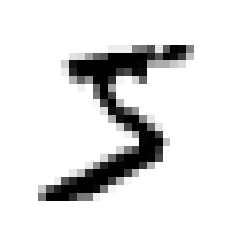

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show();

In [7]:
y[0]

'5'

In [8]:
# dtype object --> uint8
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

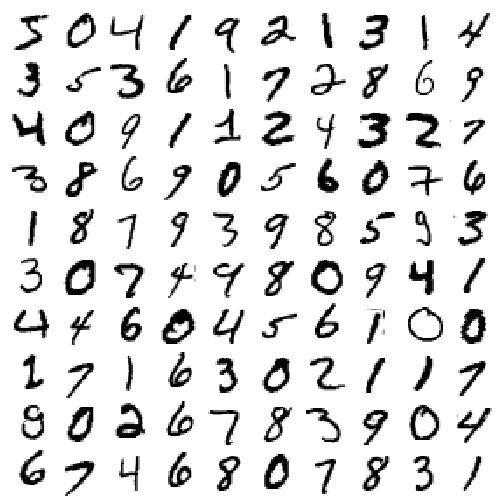

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier
# SGD -  stochastic gradient descent - Linear classifiers (SVM, logistic regression, etc.) with SGD tr  aining.
# Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting 
# linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and 
# Logistic Regression
# tol - The stopping criterion. If it is not None, training will stop when (loss > best_loss - tol)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state= 42)
# just like putting label as a second parameter, we put y_train_5. Instaed of y_train, we put y_train_5
# here y_train_5 maks everything false except 5. so, the label is true or false.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9681 , 0.95655, 0.95515])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
# StratifiedKFold - Provides train/test indices to split data in train/test sets.
# This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
#     trains with X_train, y_train and test out on X_test.
#  compare ther esult with y_test
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9681
0.95655
0.95515


In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
#         always out put as false.
        return np.zeros((len(X), 1), dtype = bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# divide into 3 sets, fit with X_train and y_train_5. predict X_train but output everything to false.
# compare with y_train_5 --> accuracy of 90%. since 10% of the data set are "5"

array([0.909  , 0.90745, 0.9125 ])

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [21]:
# row implies actual class, column indicates predicted class
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53124,  1455],
       [  949,  4472]], dtype=int64)

In [22]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.754513244474439

In [24]:
recall_score(y_train_5, y_train_pred)

0.8249400479616307

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7881565033486078

In [26]:
# check sample score and decision score used to classify
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3251.81547403])

In [27]:
threshold = 0;
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [56]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")
# think of decision function as a h(0) function or y = ax + b kind of function. the reuslt y should be 
# yes or no but we imply scores to it.
print(y_scores.max())
y_scores

35361.03224688042


array([-18922.19789678,  -9437.14784295,  -2464.76484921, ...,
        -7512.63380148, -16501.63029593, -16429.11305816])

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# precision_recall_curve - Compute precision-recall pairs for different probability thresholds
# first parameter - True binary labels. If labels are not either {-1, 1} or {0, 1}, 
# then pos_label should be explicitly given
# second parameter - Estimated probabilities or decision function.

In [53]:
# Precision values such that element i is the precision of predictions with score >= thresholds[i] 
# and the last element is 1. percentage of score higher than a threshold.
precisions

array([0.09047516, 0.09045998, 0.09046149, ..., 1.        , 1.        ,
       1.        ])

In [54]:
# Decreasing recall values such that element i is the recall of predictions with score >= thresholds[i] 
# and the last element is 0.
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [55]:
# Increasing thresholds on the decision function used to compute precision and recall.
# matches max and min y_scores of above
thresholds

array([  35362.03224688,   35361.03224688,   29390.02710484, ...,
        -71023.15967143,  -71030.97319153, -119540.06831199])

0.6640841173215274
3214.584350041131


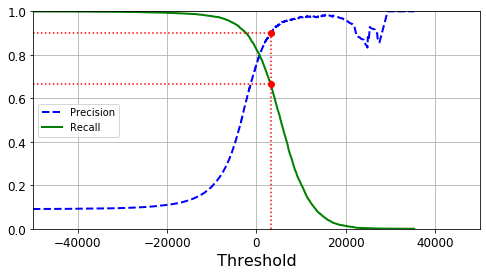

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center left")
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1]) 

# argmax - In case of multiple occurrences of the maximum values, 
# the indices corresponding to the first occurrence are returned.
# find a first value that goes above 0.9
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(recall_90_precision)
print(threshold_90_precision)

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show();

In [31]:
# aim 90% precision just comapre vector vs vecotor and count
y_train_pred_90 = (y_scores > 3000)
precision_score(y_train_5, y_train_pred_90)

0.8936585365853659

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.6758900571850213

In [33]:
# show that prediction of number 5 and the number of y_scores that goes above 0 matches
(y_train_pred == (y_scores > 0)).all()

True

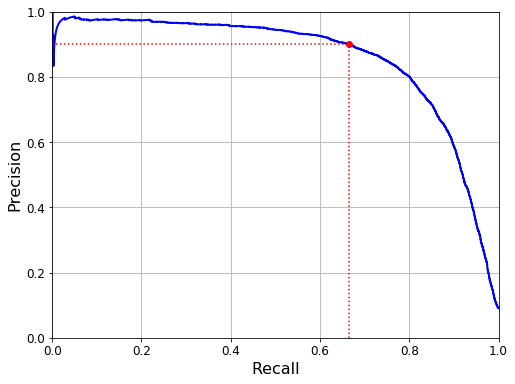

In [60]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.6640, 0.6640], [0., 0.9], "r:")
plt.plot([0.0, 0.6640], [0.9, 0.9], "r:")
plt.plot([0.6640], [0.9], "ro")
plt.show()

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3214.584350041131

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.6640841173215274

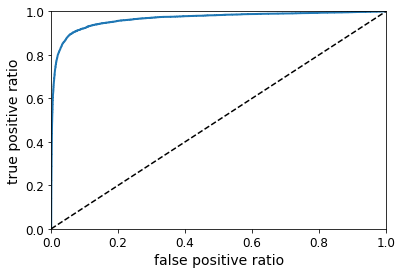

In [39]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('false positive ratio')
    plt.ylabel('true positive ratio')
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9660259463088996

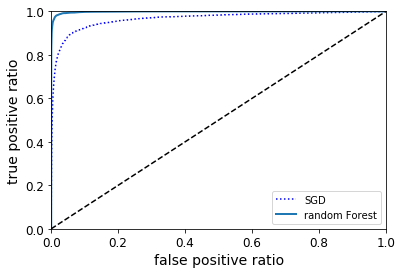

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_score_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random Forest")
plt.legend(loc="lower right")

In [42]:
roc_auc_score(y_train_5, y_score_forest)

0.9983631764491033

In [65]:
# Multiclass classification
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([ True])

In [100]:
# ouput comes out as an score of number in array if we put y_train data into the fit
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-21615.39389421, -36106.66306547,  -9085.34162979,
          3025.25933537, -36357.90773687,   1925.72172007,
        -19655.38343911, -16914.54767509, -14099.54704496,
        -11911.74666988]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [101]:
np.argmax(some_digit_scores)

3

In [102]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [103]:
# same process with SVC
from sklearn.svm import SVC
# SVC = C-Support Vector Classification
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([8], dtype=uint8)

In [104]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 8.16593933,  7.15880384,  3.98277096, -0.2062723 ,  2.89912035,
         1.87138996,  0.83996083,  6.12150827,  9.17832647,  5.01230928]])

In [105]:
np.argmax(some_digit_scores)

8

In [83]:
print(svm_clf.classes_)
svm_clf.classes_[8]

[0 1 2 3 4 5 6 7 8 9]


8

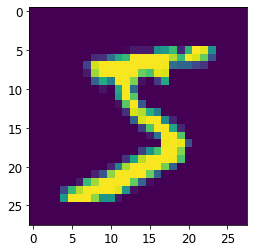

In [106]:
plt.imshow(some_digit.reshape(28,28))

In [84]:
from sklearn.multiclass import OneVsOneClassifier
# OneVsOneClassifier - This strategy consists in fitting one classifier per class pair. 
# At prediction time, the class which received the most votes is selected. 
ovo_clf = OneVsOneClassifier(SVC(gamma='auto', random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])

array([8], dtype=uint8)

In [107]:
len(ovo_clf.estimators_)

45

In [108]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [109]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.  , 0.03, 0.06, 0.  , 0.88, 0.  , 0.01, 0.01, 0.  ]])

In [110]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.96565, 0.96655, 0.9652 ])

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_train_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90425, 0.9031 , 0.8903 ])

In [115]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

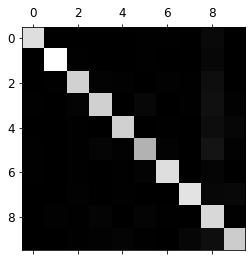

In [93]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [94]:
# out of its' prediction which result comes out bad
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

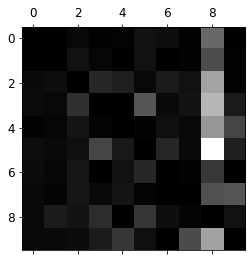

In [95]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

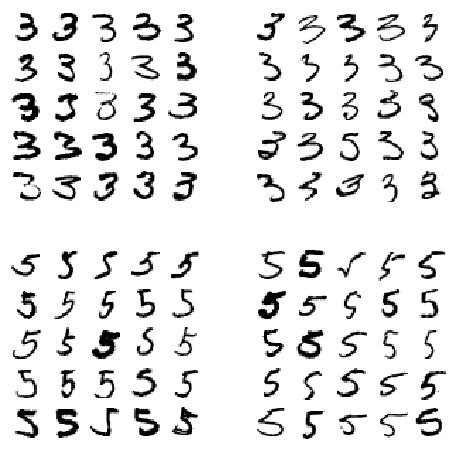

In [96]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# actual 3 and predicted 5 --> how many 5 gets confused into 3?
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [97]:
# Multilabel classification
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [98]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [99]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, aerage="macro")

KeyboardInterrupt: 

In [119]:
import numpy.random as rnd
# multioutput classification
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

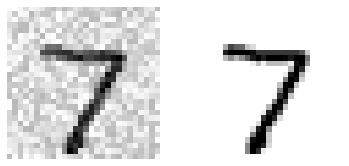

In [120]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

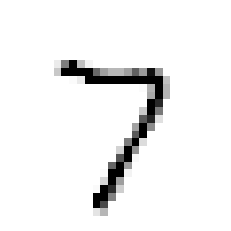

In [123]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Counter({0.0: 54616, 1.0: 5384})


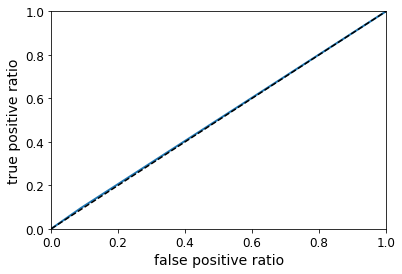

In [148]:
# Extra material
import collections;
from sklearn.dummy import DummyClassifier
# DummyClassifier - When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. 
# DummyClassifier implements several such simple strategies for classification
dmy_clf = DummyClassifier(strategy='stratified')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]
print(collections.Counter(y_scores_dmy))
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

(60000, 784)

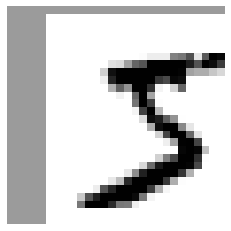

In [162]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)
# cval = Value to fill past edges of input when input cannot fill the whole figure
# higher the number, darker it gets
plot_digit(shift_digit(some_digit, 5, 1, new=100))

X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
#    axis =1 --> think as if whole column becomes one element 
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape; # (300000, 784)
y_train_expanded.shape;
X_train.shape

In [166]:
X_train_expanded.shape

(300000, 784)

In [160]:
# np.apply_along_axis example
def my_func(a):
    """Average first and last element of a 1-D array"""
    return (a[0] + a[-1]) * 0.5
b = np.array([[1,2,3], [4,5,6], [7,8,9]])
np.apply_along_axis(my_func, 0, b)
np.array([4., 5., 6.])
np.apply_along_axis(my_func, 1, b)
np.array([2.,  5.,  8.])

array([2., 5., 8.])

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)